In [ ]:
# Read metrics from MLflow
import mlflow

run_ids = ['b05ff27ac9cd434c8422b3aaeb6a2bcd']
metric_keys = ['eval_accuracy', 'eval_loss', 'eval_macro_f1', 'grad_norm', 'loss']
result = []

for metric_key in metric_keys:
  for run_id in run_ids:
    run = mlflow.get_run(run_id)
    history = mlflow.MlflowClient().get_metric_history(run_id, metric_key)
    run_name = run.info.run_name
    for metric in history:
      result.append(
        {
          "run_name": run_name,
          "run_id": run_id,
          "metric_key": metric_key,
          "timestamp": metric.timestamp,
          "step": metric.step,
          "value": metric.value,
        }
      )

current_metric = ""
for r in result:
    if r['metric_key'] != current_metric:
        current_metric = r['metric_key']
        print(f"--- {current_metric} ---")
    print(f"{r['step']}, {r['value']:6f}")


--- eval_accuracy ---
6136, 0.743046
12272, 0.760571
18408, 0.766684
24544, 0.774733
30680, 0.778299
36816, 0.770555
42952, 0.780540
--- eval_loss ---
6136, 0.260152
12272, 0.245664
18408, 0.244887
24544, 0.224374
30680, 0.253584
36816, 0.266983
42952, 0.292273
--- eval_macro_f1 ---
6136, 0.743256
12272, 0.759984
18408, 0.766045
24544, 0.771435
30680, 0.775569
36816, 0.771784
42952, 0.780207
--- grad_norm ---
1022, 3.750586
2044, 3.092508
3066, 2.849662
4088, 3.544153
5110, 2.962558
6132, 3.059551
7154, 2.481273
8176, 2.425777
9198, 3.024428
10220, 2.784454
11242, 2.401860
12264, 3.541090
13286, 3.110585
14308, 2.511896
15330, 3.875180
16352, 5.307340
17374, 3.460467
18396, 3.124600
19418, 3.123239
20440, 3.391132
21462, 2.064321
22484, 4.573524
23506, 1.712668
24528, 2.758032
25550, 8.756660
26572, 3.941511
27594, 4.906476
28616, 1.284494
29638, 2.323006
30660, 3.878440
31682, 1.655721
32704, 4.591517
33726, 1.936713
34748, 2.168209
35770, 5.522344
36792, 3.317699
37814, 3.038477
3883

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Tokenizing: 100%|██████████| 9815/9815 [00:00<00:00, 66777.88 examples/s]


Max length of tokenized dataset: 445


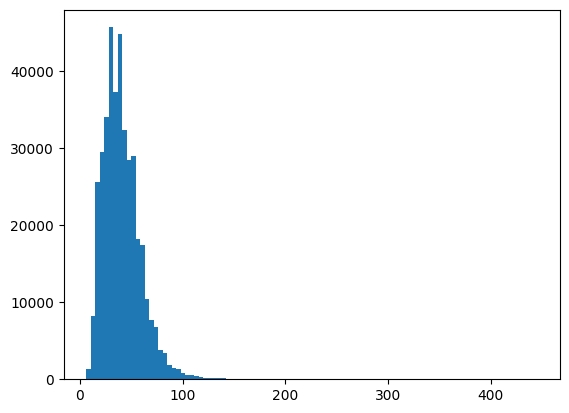

Percentage of samples longer than 64 tokens: 9.73%
Percentage of samples longer than 128 tokens: 0.31%
Percentage of samples longer than 256 tokens: 0.02%
Percentage of samples longer than 512 tokens: 0.00%


In [6]:
# Find max length of tokenized dataset.

import datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    DataCollatorWithPadding
)
from model_fine_tune import build_contextual_dataset, preprocess_function


params = {
    "model_name": "distilbert-base-uncased",
    "max_length": 512,
}

dataset = load_dataset("nyu-mll/glue", "mnli")
dataset = datasets.DatasetDict({
    "train": dataset["train"],
    "validation": dataset["validation_matched"]
})
dataset = build_contextual_dataset(dataset)
train_labels = [int(sample["label"]) for sample in dataset['train']]
unique_labels = sorted(list(set(train_labels)))

# Setup model
model = AutoModelForSequenceClassification.from_pretrained(
    params["model_name"],
    num_labels=len(unique_labels),
    problem_type="single_label_classification"
)

# Setup tokenizer and data collator
tokenizer = AutoTokenizer.from_pretrained(params["model_name"])
special_tokens_dict = {"additional_special_tokens": ["[PREMISE]", "[HYPOTHESIS]"]}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Tokenize dataset
tokenized_datasets = dataset.map(
    lambda x: preprocess_function(
        x, tokenizer, "label", text_field="text_concat", max_length=params["max_length"]
    ),
    batched=True,
    remove_columns=dataset["train"].column_names,
    desc="Tokenizing"
)

# Find max length of tokenized dataset
lengths = [len(tokenized_datasets["train"][i]["input_ids"]) for i in range(len(tokenized_datasets["train"]))]

print(f"Max length of tokenized dataset: {max(lengths)}")

# Show the chart with the length of the tokenized dataset
plt.hist(lengths, bins=100)
plt.show()

# show what percentage of the dataset is longer than 64, 128, 256, 512 tokens
for threshold in [64, 128, 256, 512]:
    pct = sum(l > threshold for l in lengths) / len(lengths) * 100
    print(f"Percentage of samples longer than {threshold} tokens: {pct:.2f}%")

In [11]:
import datasets
from datasets import load_dataset
import json
import random

NUM_EXAMPLES = 1000
random.seed(42)

dataset = load_dataset("nyu-mll/glue", "mnli")
examples = dataset["test_matched"]

# Get random indices
indices = random.sample(range(len(examples)), NUM_EXAMPLES)

# Write selected examples to jsonl file
with open("examples.jsonl", "w") as f:
    for idx in indices:
        example = {
            "premise": examples[idx]["premise"],
            "hypothesis": examples[idx]["hypothesis"]
        }
        f.write(json.dumps(example) + "\n")
